<a href="https://colab.research.google.com/github/divya-r-kamat/END/blob/main/Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate/Twitter/02_Twitter_Seq2Seq_using_Attention_with_packed_padded_sequence_and_masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation by Jointly Learning to Align and Translate using Packed Padded Sequences, Masking and BLEU


In this notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). 
## Introduction

As a reminder, here is the attention model:

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq7.png?raw=1)


## Introduction

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. Packed padded sequences are used to tell our RNN to skip over padding tokens in our encoder. Masking explicitly forces the model to ignore certain values, such as attention over padded elements. Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

Finally, we'll use the BLEU metric to measure the quality of our translations.

## Preparing Data

Again, the preparation is similar to last time.
First, we'll import all the modules as before, with the addition of the `matplotlib` modules used for viewing the attention.

In [ ]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 1.2MB 11.5MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/Sequence-to-Sequence-using-Encoder-Decoder-and-Attention/Tweets_Seq_2_Seq

 data
'Twitter_Dataset - Learning_Phrase_Representation_RNN Encoder-Decoder.ipynb'
'Twitter_Dataset - Sequence_to_Sequence_using_Attention.ipynb'


In [ ]:
!unzip /content/drive/MyDrive/Sequence-to-Sequence-using-Encoder-Decoder-and-Attention/Tweets_Seq_2_Seq/data/archive.zip

Archive:  /content/drive/MyDrive/Sequence-to-Sequence-using-Encoder-Decoder-and-Attention/Tweets_Seq_2_Seq/data/archive.zip
  inflating: sample.csv              
  inflating: twcs/twcs.csv           


In [ ]:
!ls

drive  sample.csv  sample_data	twcs


In [ ]:
import pandas as pd
tweets = pd.read_csv('./twcs/twcs.csv')
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]
inbounds_and_outbounds = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')
inbounds_and_outbounds.head(2)

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0


In [ ]:
inbounds_and_outbounds[~inbounds_and_outbounds.author_id_y.str.isnumeric()]['author_id_y'].unique()

array(['sprintcare', 'Ask_Spectrum', 'VerizonSupport', 'ChipotleTweets',
       'AskPlayStation', 'marksandspencer', 'MicrosoftHelps',
       'ATVIAssist', 'AdobeCare', 'AmazonHelp', 'XboxSupport',
       'AirbnbHelp', 'AirAsiaSupport', 'Morrisons', 'NikeSupport',
       'AskAmex', 'YahooCare', 'AskLyft', 'UPSHelp', 'Delta', 'McDonalds',
       'AppleSupport', 'Uber_Support', 'Tesco', 'SpotifyCares',
       'British_Airways', 'comcastcares', 'AmericanAir', 'TMobileHelp',
       'VirginTrains', 'SouthwestAir', 'AskeBay', 'hulu_support',
       'GWRHelp', 'sainsburys', 'AskPayPal', 'HPSupport', 'ChaseSupport',
       'CoxHelp', 'DropboxSupport', 'VirginAtlantic', 'BofA_Help',
       'AzureSupport', 'AlaskaAir', 'ArgosHelpers', 'Postmates_Help',
       'AskTarget', 'GoDaddyHelp', 'CenturyLinkHelp', 'AskPapaJohns',
       'SW_Help', 'nationalrailenq', 'askpanera', 'Walmart',
       'USCellularCares', 'AsurionCares', 'GloCare', 'idea_cares',
       'DoorDash_Help', 'NeweggService', 'VirginA

In [ ]:
x = inbounds_and_outbounds[(inbounds_and_outbounds['author_id_y'] == 'SpotifyCares')]

inbounds_and_outbounds = x[inbounds_and_outbounds.inbound_y ^ True]
print(f'Data shape: {inbounds_and_outbounds.shape}')

Data shape: (26940, 14)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
inbounds_and_outbounds.reset_index(drop=True).head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,855,115887,True,Tue Oct 31 19:10:51 +0000 2017,i’m pissed my @115888 shuffle and repeat butto...,854,NaN,854,SpotifyCares,False,Tue Oct 31 19:36:16 +0000 2017,"@115887 Hey! What device, operating system, an...",853,855.0
1,862,115889,True,Tue Oct 31 21:43:56 +0000 2017,@SpotifyCares @115890 Groove Music quits &amp;...,860,NaN,860,SpotifyCares,False,Tue Oct 31 21:51:22 +0000 2017,@115889 Hey there! That doesn't sound good. Wh...,"861,858",862.0
2,866,115891,True,Tue Oct 31 22:14:42 +0000 2017,is there a way to find non-explicit songs that...,865,NaN,865,SpotifyCares,False,Tue Oct 31 22:17:55 +0000 2017,@115891 Hey Mikey! We're afraid there's no way...,864,866.0
3,1875,116128,True,Tue Oct 31 22:24:54 +0000 2017,Why are my devices not doing the cool thing wh...,1874,NaN,1874,SpotifyCares,False,Tue Oct 31 22:32:21 +0000 2017,@116128 Hey Jacklynn! The cavalry's here. Coul...,1869,1875.0
4,1878,116129,True,Tue Oct 31 21:54:36 +0000 2017,@116130 why are Nena's releases between 2002 a...,1876,NaN,1876,SpotifyCares,False,Tue Oct 31 22:33:32 +0000 2017,@116129 Hi Liam! Could you let us know the tra...,1877,1878.0


In [ ]:
inbounds_and_outbounds.text_y = inbounds_and_outbounds.text_y.replace(to_replace ="^@[0-9]+",
                 value ="",regex = True) 
inbounds_and_outbounds.text_x = inbounds_and_outbounds.text_x.replace(to_replace ="^@SpotifyCares",
                 value ="",regex = True) 
inbounds_and_outbounds.text_x = inbounds_and_outbounds.text_x.replace(to_replace ="^@[0-9]+",
                 value ="",regex = True) 

In [ ]:
# Import Library
import random
import torch, torchtext
from torchtext import data 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from torchtext.data import Field, BucketIterator
import spacy
import numpy as np
import math
import time

In [ ]:
#Then set a random seed for deterministic results/reproducability.
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Create our fields to process our data. This will append the "start of sentence" and "end of sentence" tokens as well as converting all words to lowercase.

When using packed padded sequences, we need to tell PyTorch how long the actual (non-padded) sequences are. Luckily for us, TorchText's `Field` objects allow us to use the `include_lengths` argument, this will cause our `batch.src` to be a tuple. The first element of the tuple is the same as before, a batch of numericalized source sentence as a tensor, and the second element is the non-padded lengths of each source sentence within the batch.

In [ ]:
SRC= data.Field(sequential = True, tokenize = 'spacy',init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,include_lengths=True)
TRG = data.Field(sequential = True, tokenize = 'spacy',init_token='<sos>', 
            eos_token='<eos>', 
            lower=True)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [ ]:
fields = [('text_x', SRC),('text_y',TRG)]

In [ ]:
inbounds_and_outbounds.text_x.iloc[0]

'i’m pissed my @115888 shuffle and repeat button just don’t fucking work and i’m getting frustrated'

Armed with our declared fields, lets convert from pandas to list to torchtext. 

In [ ]:
example = [data.Example.fromlist([inbounds_and_outbounds.text_x.iloc[i],inbounds_and_outbounds.text_y.iloc[i]], fields) for i in range(inbounds_and_outbounds.shape[0])] 

Creating dataset

In [ ]:
twitterDataset = data.Dataset(example, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [ ]:
(train_data, valid_data,test_data) = twitterDataset.split(split_ratio=[0.80, 0.10,0.10], random_state=random.seed(SEED))

In [ ]:
(len(train_data), len(valid_data),len(test_data))

(21552, 2694, 2694)

In [ ]:
print(vars(train_data.examples[0]))

{'text_x': [' ', 'hey', 'i', 'have', 'a', 'i', "'m", 'under', 'a', 'family', 'plan', 'and', 'i', 'ended', 'up', 'paying', 'for', 'the', 'month', 'plan', 'by', 'acsident', 'so', 'we', 'have', 'payed', '2x', 'for', 'the', 'same', 'account', 'we', 'just', 'wondering', 'if', 'there', "'s", 'anything', 'that', 'can', 'be', 'done', 'to', 'help', 'this', 'situation'], 'text_y': [' ', 'hey', '!', 'the', 'cavalry', "'s", 'here', '.', 'can', 'you', 'dm', 'us', 'your', 'account', "'s", 'username', 'or', 'email', 'address', '?', 'we', "'ll", 'take', 'a', 'look', 'under', 'the', 'hood', '/js', 'https://t.co/ldfdzrinat']}


Then create our vocabulary, converting all tokens appearing less than twice into <unk> tokens.

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Finally, define the device and create our iterators.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

For packed padded sequences is that all elements in the batch need to be sorted by their non-padded lengths in descending order, i.e. the first sentence in the batch needs to be the longest. We use two arguments of the iterator to handle this, sort_within_batch which tells the iterator that the contents of the batch need to be sorted, and sort_key a function which tells the iterator how to sort the elements in the batch. Here, we sort by the length of the src sentence

In [ ]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x : len(x.text_x),
    sort_within_batch=True, 
    device = device)

### Building the Seq2Seq Model


This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as **appropriate**

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs


### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq8.png?raw=1)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.


After the source sentence (padded automatically within the iterator) has been embedded, we can then use pack_padded_sequence on it with the lengths of the sentences. packed_embedded will then be our packed padded sequence. This can be then fed to our RNN as normal which will return packed_outputs, a packed tensor containing all of the hidden states from the sequence, and hidden which is simply the final hidden state from our sequence. hidden is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final non-padded element in the sequence.

We then unpack our packed_outputs using pad_packed_sequence which returns the outputs and the lengths of each, which we don't need.

The first dimension of outputs is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. The attention module is where we calculate the attention values over the source sentence.  This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 


Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq9.png?raw=1)


Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](https://github.com/bentrevett/pytorch-seq2seq/blob/master/assets/seq2seq10.png?raw=1)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

# Training the Seq2Seq Model

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). The embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from  N(0,0.01) .

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7928, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(3444, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=3444, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We print out the number of parameters.

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,519,604 trainable parameters


We initiaize our optimizer.

In [ ]:
optimizer = optim.Adam(model.parameters())

We also initialize the loss function, making sure to ignore the loss on `<pad>` tokens.

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.text_x
        src_len=src_len.cpu()
        trg = batch.text_y
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to eval mode and turn off teaching forcing.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.text_x
            src_len=src_len.cpu()

            trg = batch.text_y

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We'll also define the function that calculates how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 38s
	Train Loss: 3.972 | Train PPL:  53.095
	 Val. Loss: 5.239 |  Val. PPL: 188.491
Epoch: 02 | Time: 1m 41s
	Train Loss: 2.898 | Train PPL:  18.144
	 Val. Loss: 5.425 |  Val. PPL: 226.905
Epoch: 03 | Time: 1m 41s
	Train Loss: 2.449 | Train PPL:  11.581
	 Val. Loss: 5.803 |  Val. PPL: 331.273
Epoch: 04 | Time: 1m 41s
	Train Loss: 2.197 | Train PPL:   8.997
	 Val. Loss: 5.890 |  Val. PPL: 361.268
Epoch: 05 | Time: 1m 41s
	Train Loss: 2.036 | Train PPL:   7.658
	 Val. Loss: 5.992 |  Val. PPL: 400.205
Epoch: 06 | Time: 1m 41s
	Train Loss: 1.968 | Train PPL:   7.155
	 Val. Loss: 5.914 |  Val. PPL: 370.353
Epoch: 07 | Time: 1m 40s
	Train Loss: 1.833 | Train PPL:   6.250
	 Val. Loss: 6.078 |  Val. PPL: 436.323
Epoch: 08 | Time: 1m 42s
	Train Loss: 1.759 | Train PPL:   5.804
	 Val. Loss: 6.352 |  Val. PPL: 573.812
Epoch: 09 | Time: 1m 41s
	Train Loss: 1.691 | Train PPL:   5.423
	 Val. Loss: 6.357 |  Val. PPL: 576.352
Epoch: 10 | Time: 1m 41s
	Train Loss: 1.656 | Train PPL

Finally, we test the model on the test set using these "best" parameters.

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.267 | Test PPL: 193.858 |


## Inference

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    src_len=src_len.cpu()
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 12

src = vars(train_data.examples[example_idx])['text_x']
trg = vars(train_data.examples[example_idx])['text_y']

print(f'question = {src}')
print(f'answer = {trg}')

question = [' ', 'i', "'m", 'interested', 'in', 'your', 'company', "'s", 'history', 'but', 'what', "'s", 'up', 'with', 'all', 'these', 'versions', 'of', 'the', 'spotify', 'company', '?', 'ab', ',', 'limited', ',', 'technology', 's.a', ',', 'etc', '.', 'i', "'d", 'love', 'to', 'get', 'some', 'clarity', 'on', 'this', 'topic', '!']
answer = [' ', 'hey', 'jazari', '.', 'it', "'d", 'be', 'best', 'to', 'reach', 'out', 'to', 'our', 'press', 'team', 'at', 'https://t.co/p0lldlbp30', '.', 'they', 'should', 'be', 'able', 'to', 'lend', 'a', 'hand', '.', 'let', 'us', 'know', 'if', 'there', "'s", 'anything', 'else', '🙂', '/ay']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = [' ', 'hey', 'there', '!', 'we', "'re", 'here', '!', 'we', '’d', 'love', 'to', 'have', 'it', 'soon', ',', 'but', 'we', "'ll", 'be', 'sure', 'to', 'have', 'it', 'soon', ',', '<eos>']


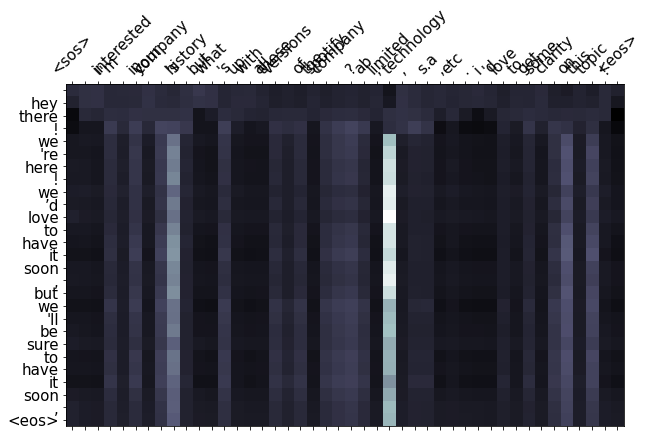

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 14

src = vars(train_data.examples[example_idx])['text_x']
trg = vars(train_data.examples[example_idx])['text_y']

print(f'question = {src}')
print(f'answer = {trg}')

question = [' ', 'why', 'ca', "n't", 'i', 'see', 'any', 'tracks', '?', 'any', 'idea', '?', 'https://t.co/hpwthiwbrq', 'https://t.co/21knailrmc']
answer = [' ', 'hey', '!', 'can', 'you', 'dm', 'us', 'your', 'account', "'s", 'username', 'and', 'email', 'address', '?', 'we', "'ll", 'take', 'a', 'look', 'backstage', '/jl', 'https://t.co/ldfdzrinat']


predicted trg = [' ', 'hey', 'there', '!', 'we', "'ve", 'just', 'sent', 'a', 'dm', 'us', 'your', 'account', "'s", 'email', 'address', '?', 'we', "'ll", 'take', 'a', 'look', 'backstage', 'the', 'https://t.co/ldfdzrinat', '<eos>']


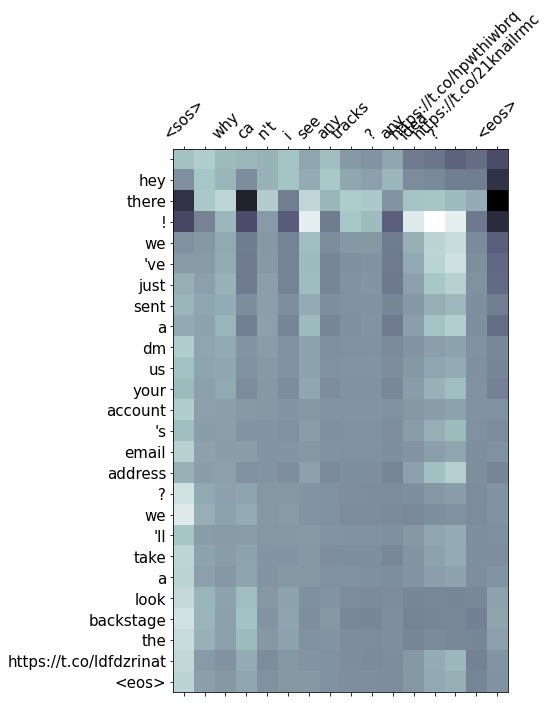

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [ ]:
example_idx = 18

src = vars(train_data.examples[example_idx])['text_x']
trg = vars(train_data.examples[example_idx])['text_y']

print(f'question = {src}')
print(f'answer = {trg}')

question = ['.@115888', '@129941', 'is', 'there', 'a', 'reason', '"', 'one', 'christmas', 'catalogue', '"', 'by', 'captain', 'sensible', 'is', "n't", 'available', '...']
answer = [' ', 'hey', '!', 'fingers', 'crossed', 'we', "'ll", 'be', 'able', 'to', 'have', 'it', 'soon', ',', 'but', 'there', "'s", 'info', 'about', 'spotify', 'content', 'here', ':', 'https://t.co/0i8gpimuda', '/k']


predicted trg = [' ', 'hey', 'there', '!', 'we', '’d', 'love', 'to', 'have', 'all', 'of', 'their', 'stuff', 'available', 'to', 'have', 'it', 'soon', ',', 'but', 'we', "'ll", 'see', 'what', 'we', "'ll", 'see', 'what', 'we', "'ll", 'see', 'what', 'we', "'ll", 'see', 'what', 'we', "'ll", 'see', 'what', 'we', "'ll", 'see', 'what', 'we', "'ll", 'see', 'what', 'we', "'ll"]


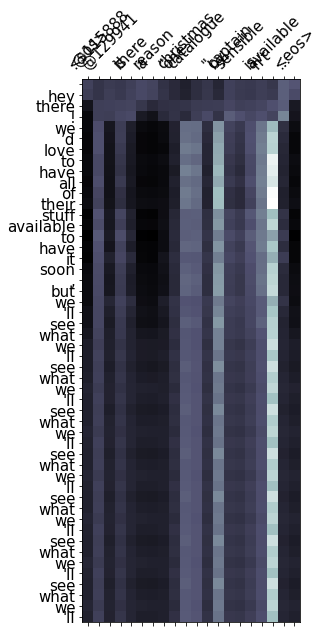

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)